## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

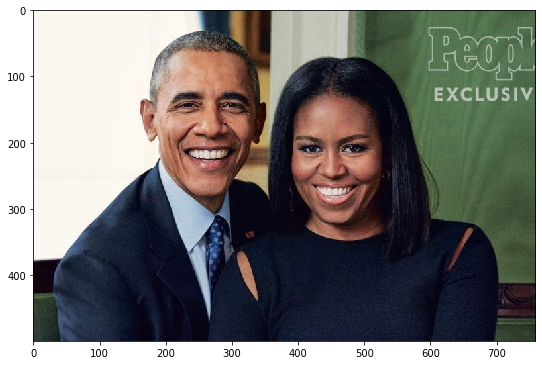

In [210]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


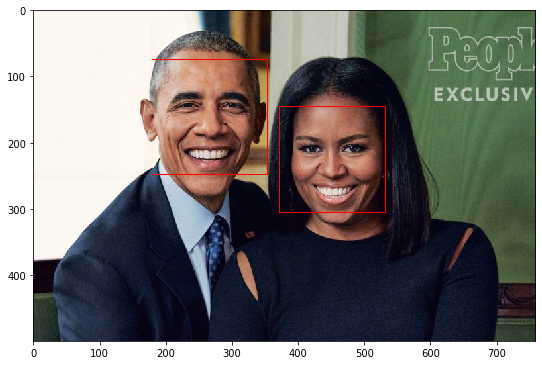

In [211]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),1) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [212]:
import torch
from models import Net

net = Net.load("./saved_models/two_consecutive_conv2d.pt")

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you'll wrap that Tensor in a Variable() and can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




In [225]:
def plot_detected_key_points(image, faces, dh=0, dw=0):
    fig = plt.figure(figsize=(20,10))
    # loop over the detected faces from your haar cascade
    for i, (x,y,w,h) in enumerate(faces):
        # Select the region of interest that is the face in the image 
        min_height = max(y-dh, 0)
        max_height = min(y+h+dh, image.shape[0])
        min_width = max(x-dw, 0)
        max_width = min(x+w+dw, image.shape[1])
        roi_ori = image[min_height:max_height, min_width:max_width]
        #roi_ori = image.copy()
        ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
        roi_ori = cv2.resize(roi_ori, (224, 224))
        ## TODO: Convert the face region from RGB to grayscale
        roi = cv2.cvtColor(roi_ori, cv2.COLOR_RGB2GRAY)
        ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
        roi = roi / 255.
        ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
        roi = roi.reshape(roi.shape[0], roi.shape[1], 1, 1)
        roi = roi.transpose((2, 3, 0, 1))
        roi = torch.from_numpy(roi).float()
        ## TODO: Make facial keypoint predictions using your loaded, trained network 
        ## perform a forward pass to get the predicted facial keypoints
        keypoints = net.predict(roi)[0]
        keypoints = keypoints.view(68, -1).data.numpy() * 50. + 100.
        ## TODO: Display each detected face and the corresponding keypoints
        ax = fig.add_subplot(1, len(faces), i+1)
        ax.imshow(roi_ori)
        ax.scatter(keypoints[:, 0], keypoints[:, 1])
    plt.show()

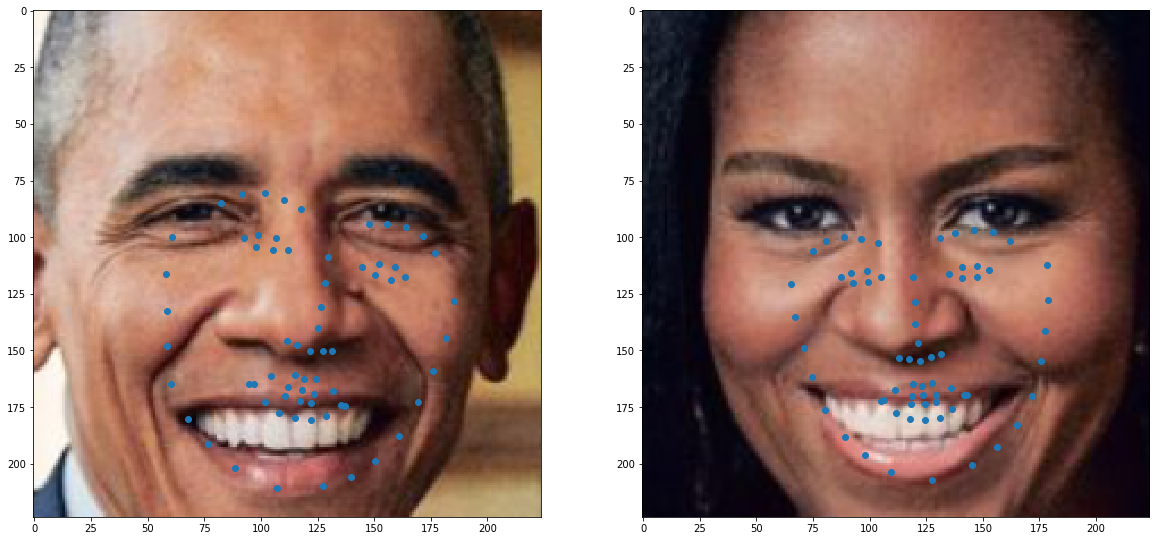

In [226]:
image_copy = np.copy(image)
plot_detected_key_points(image_copy, faces)

<img src="./images/doh.png">

Sorry for the joke, It really was my feeling after I see the result and I wanted to share it. Ok it's bad. I think that the network I have trained does not generalize well with "close-ups". The cascade detector is making this close up and none of the image I have been used for training (or validating) the network is actually a close up. Most faces were occupying kind of the same place in the picture. One way to fix the issue would be to add a data transformation doing something to what the Haar Cascade does, turning the image in some kind of close-up.

One way to do that would be to increase the size of the rescale data transformation so that the random crop actually zooms in more. But this might lead to have actual key points outside of the image and might slow the convergence down.

Another way would have to have a transformation doing a face detection with the same kind of Haar Cascade. But depending on the picture, the cascade parameters might not be adapted and fails to detect a face which in turn might cause issues in the learning of the algorithm. But because there are mostly single people on the training and validating dataset and that portion of face in the image is similar from pictures to pictures it shall be possible to use the same parameters (scale factor and minimum neighbours) for all images.

I am using a little trick to extract a bigger rectangle from the image than what Haar Cascade would normally do, and here is what we get now:

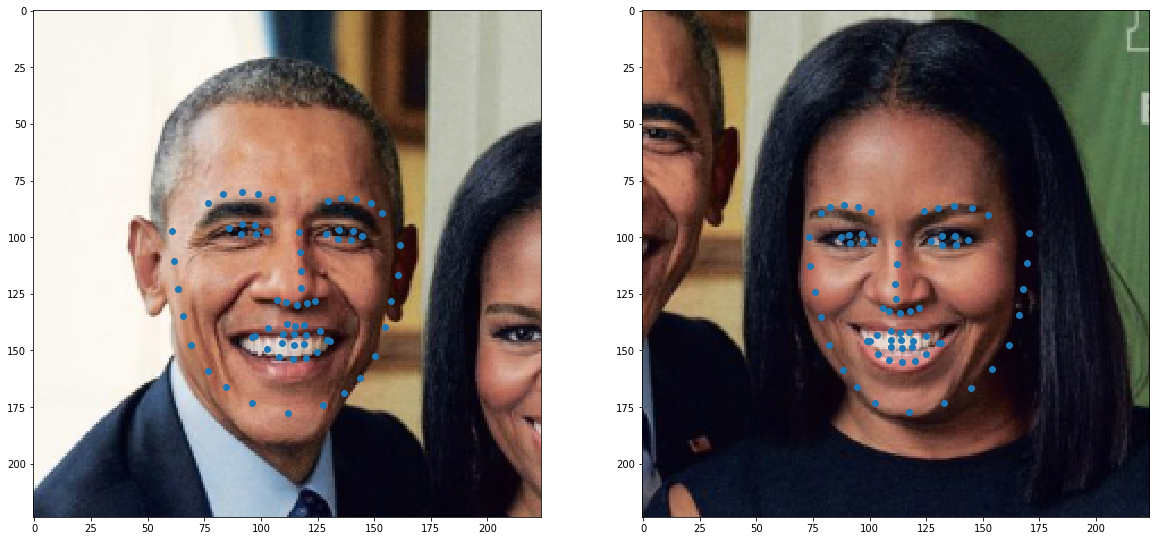

In [230]:
plot_detected_key_points(image_copy, faces, dh=80, dw=80)

Prediction is much better now. This confirms my assumption regarding the non-generalization of my trained network to close-ups.